In [16]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths
import sys

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow.keras import mixed_precision
from tensorflow import keras # ML
import tensorflow_addons as tfa # TQDM progress bar when training
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

BATCH_SIZE = 128

mixed_precision.set_global_policy('mixed_float16')


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path # Pathing
from glob import glob # Finding files recursively
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

BASE_DIR = Path("EmbryoLabeling/Labelers/train")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = folder
    files.append(files_in_folder)
df = pd.concat(files)
df["class"].value_counts()

Empty                  5797
Morula                 1319
2pn                    1039
Syngamy                 834
4 Cell                  792
2 Cell                  736
Compacting 8 cell       549
Expanded Blastocyst     394
8 Cell                  384
Blastocyst              374
6 Cell                  360
Cavitating morula       324
3 Cell                  303
Early blast             291
5 Cell                  130
Name: class, dtype: int64

<AxesSubplot:>

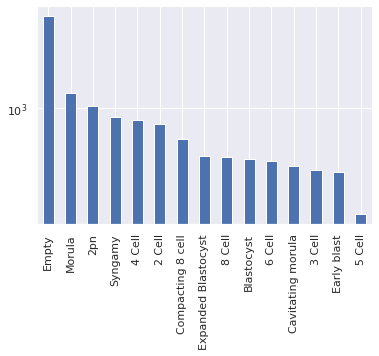

In [17]:
df["class"].value_counts().plot.bar(logy=True)

In [18]:
# Print counts of images by machine and slide
df.filename[~df["class"].isin(["bad", "Empty"])].apply(lambda s: s.split("/")[-1].split("_")[:2]).value_counts()

[M0776, S00512]    1952
[M776, S0087]      1559
[M0776, S00635]    1294
[M0776, S00761]    1138
[M0776, S00534]    1102
[M0776, S00470]     784
Name: filename, dtype: int64

In [19]:
# Track a single embryo's lifecycle
pd.set_option('display.max_rows', 365)
M776_S0087_W2 = df[df.filename.str.contains("M776_S0087_W2")].copy()
# Extract time since fertilisation in minutes from filename (ints, rounded to nearest minute)
M776_S0087_W2["time_since_fert"] = M776_S0087_W2.filename.apply(lambda s: s.replace(".jpg", "").split("_")[-1]).astype(int)
M776_S0087_W2 = M776_S0087_W2.sort_values(by="time_since_fert")
# Take the earliest time that each class was seen
M776_S0087_W2 = M776_S0087_W2.groupby("class").head(1)
print(M776_S0087_W2[["class", "time_since_fert"]])

                  class  time_since_fert
511                 2pn             1061
685             Syngamy             1464
298              2 Cell             1574
116              3 Cell             2315
104              4 Cell             2395
7                5 Cell             3045
29               6 Cell             3125
145              8 Cell             3265
24    Compacting 8 cell             3375
1169             Morula             4286
199   Cavitating morula             5940
50          Early blast             6090
113          Blastocyst             6261
4850              Empty             7036


In [20]:
classes = list(M776_S0087_W2["class"])
classes

['2pn',
 'Syngamy',
 '2 Cell',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 'Compacting 8 cell',
 'Morula',
 'Cavitating morula',
 'Early blast',
 'Blastocyst',
 'Empty']

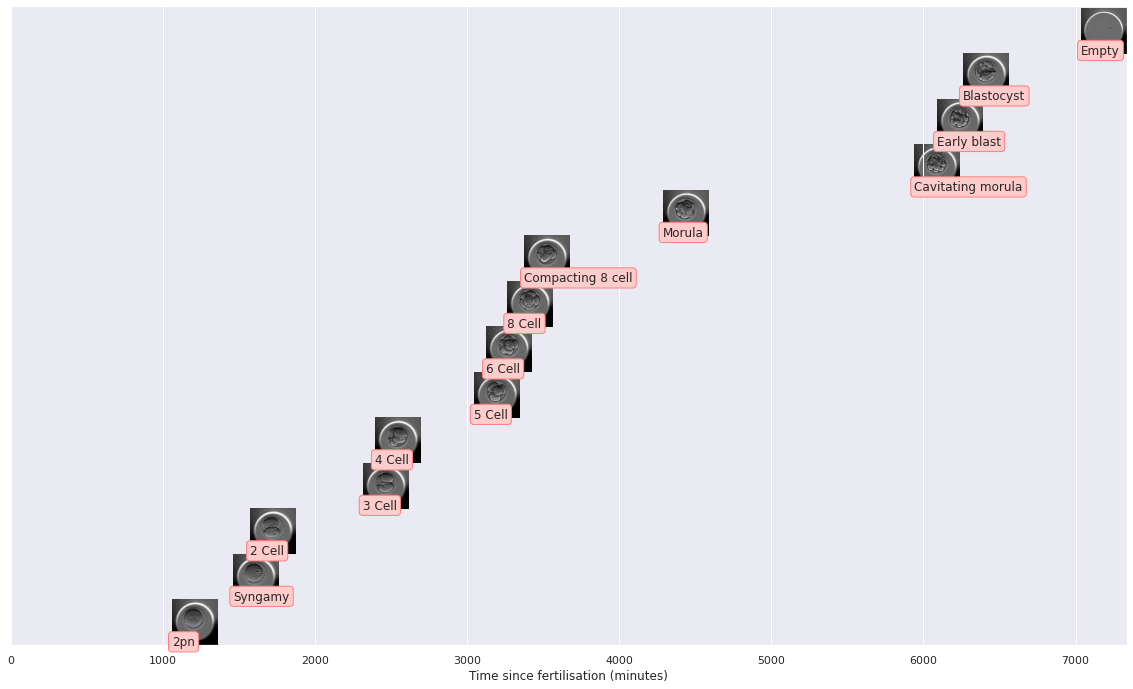

In [21]:
# Plot embryo's lifecycle over time
plt.figure(figsize=(20, 20))
for i, row in M776_S0087_W2.iterrows():
    image = keras.utils.load_img(row.filename, target_size=(299,299))
    c_index = classes.index(row["class"]) * 299
    time_since_fert = row.time_since_fert
    plt.imshow(image, extent=[time_since_fert, time_since_fert+299, c_index, c_index+299])
    plt.text(time_since_fert, c_index, row["class"], bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
plt.yticks([])
plt.xlabel("Time since fertilisation (minutes)")
plt.xlim(0, M776_S0087_W2.time_since_fert.max() + 300)
plt.ylim(0, len(classes) * 300)
plt.show()

In [22]:
train = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR,
    image_size = (299,299),
    batch_size = BATCH_SIZE,
    label_mode = 'categorical',
    shuffle = False
)
train_cache = train.cache().prefetch(tf.data.AUTOTUNE)

Found 13626 files belonging to 15 classes.


In [23]:
len(train_cache)

107

In [24]:
_ = list(tqdm(train_cache)) # load it all into RAM

  0%|          | 0/107 [00:00<?, ?it/s]

In [31]:
class AugmentationGenerator(tf.keras.utils.Sequence):
    def __getitem__(self, idx):
        x, y = next(iter(train_cache.skip(idx).take(1)))
        x = np.vstack([
            x,
            np.flip(x, axis=1),
            np.flip(x, axis=2),
            np.flip(np.flip(x, axis=1), axis=2),
        ])
        y = np.vstack([
            y, y, y, y
        ])
        return x, y
    def __len__(self):
        return len(train_cache)

x, y = AugmentationGenerator().__getitem__(0)
print(x.shape, y.shape)

(512, 299, 299, 3) (512, 15)


In [32]:
len(AugmentationGenerator())

107

In [33]:
classes = train.class_names
classes

['2 Cell',
 '2pn',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 'Blastocyst',
 'Cavitating morula',
 'Compacting 8 cell',
 'Early blast',
 'Empty',
 'Expanded Blastocyst',
 'Morula',
 'Syngamy']

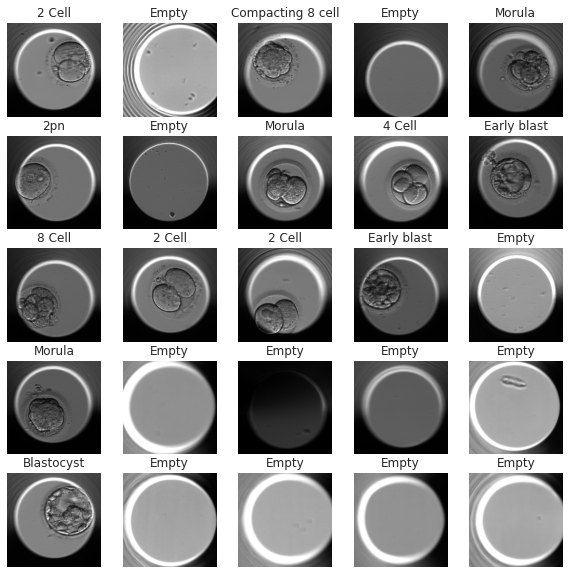

In [34]:
plt.figure(figsize=(10, 10))
for i, (idx, row) in enumerate(df.sample(25).iterrows()):
    ax = plt.subplot(5, 5, i + 1)
    image = keras.utils.load_img(row.filename, target_size=(299,299))
    plt.imshow(image)
    plt.title(row["class"])
    plt.axis("off")

In [35]:
base_model = keras.Sequential([
    # Pre-trained Xception weights requires that input be scaled
    # from (0, 255) to a range of (-1., +1.), the rescaling layer
    # outputs: `(inputs * scale) + offset`
    keras.layers.Rescaling(scale=1./127.5, offset=-1, input_shape=(299,299,3)),
    keras.applications.Xception(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        include_top=False,
        pooling="avg"
    )
])
base_model.save(f"models/xception.h5")
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
Total params: 20,861,480
Trainable params: 20,806,952
Non-trainable params: 54,528
_________________________________________________________________


In [36]:
extracted_features = base_model.predict(AugmentationGenerator())

107/107 [==============================] - 173s 2s/step


In [37]:
extracted_features.shape

(54504, 2048)

In [50]:
y = np.vstack([np.vstack([y,y,y,y]) for x,y in train])
y.shape

(54504, 15)

In [57]:
file_paths = pd.concat([pd.Series(train.file_paths)] * 4).reset_index(drop=True)
file_paths

0        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W2_F0_1894.jpg
1        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W2_F0_1914.jpg
2        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W2_F0_1934.jpg
3        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W2_F0_1954.jpg
4        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W2_F0_1974.jpg
                                       ...                               
54499     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1555.jpg
54500     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1585.jpg
54501     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1605.jpg
54502     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1625.jpg
54503     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1645.jpg
Length: 54504, dtype: object

In [58]:
#x_train, x_test, y_train, y_test = train_test_split(extracted_features, y, test_size=.2)

# Use one slide for test, everything else for train
test_idx = file_paths.str.contains("M0776_S00512")
x_train = extracted_features[~test_idx]
y_train = y[~test_idx]
x_test = extracted_features[test_idx]
y_test = y[test_idx]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((45356, 2048), (45356, 15), (9148, 2048), (9148, 15))

In [62]:
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1))
class_weights = dict(enumerate(class_weights))
{k:v for k,v in zip(classes, class_weights.values())}

{'2 Cell': 1.3589812734082396,
 '2pn': 0.9413864674138647,
 '3 Cell': 2.494829482948295,
 '4 Cell': 1.017749354874902,
 '5 Cell': 8.972502472799208,
 '6 Cell': 2.597709049255441,
 '8 Cell': 2.5303207810320782,
 'Blastocyst': 2.5843874643874645,
 'Cavitating morula': 3.3046265938069217,
 'Compacting 8 cell': 1.6460170567955,
 'Early blast': 3.216737588652482,
 'Empty': 0.15590272406977743,
 'Expanded Blastocyst': 2.5690172755593315,
 'Morula': 0.6178449802479227,
 'Syngamy': 1.114945919370698}

In [63]:
%%time
model = keras.Sequential([
    keras.layers.Input(shape=(2048)),
    keras.layers.Dense(len(classes), activation="softmax")
])
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)
print(model.summary())
history = model.fit(x_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_test, y_test),
                    epochs=500,
                    verbose=0,
                    class_weight=class_weights,
                    callbacks=[
                        keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',patience=50, verbose=1),
                        tfa.callbacks.TQDMProgressBar()
                    ])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 15)                30735     
                                                                 
Total params: 30,735
Trainable params: 30,735
Non-trainable params: 0
_________________________________________________________________
None


Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Epoch 1/500


0/355           ETA: ?s - 

Epoch 2/500


0/355           ETA: ?s - 

Epoch 3/500


0/355           ETA: ?s - 

Epoch 4/500


0/355           ETA: ?s - 

Epoch 5/500


0/355           ETA: ?s - 

Epoch 6/500


0/355           ETA: ?s - 

Epoch 7/500


0/355           ETA: ?s - 

Epoch 8/500


0/355           ETA: ?s - 

Epoch 9/500


0/355           ETA: ?s - 

Epoch 10/500


0/355           ETA: ?s - 

Epoch 11/500


0/355           ETA: ?s - 

Epoch 12/500


0/355           ETA: ?s - 

Epoch 13/500


0/355           ETA: ?s - 

Epoch 14/500


0/355           ETA: ?s - 

Epoch 15/500


0/355           ETA: ?s - 

Epoch 16/500


0/355           ETA: ?s - 

Epoch 17/500


0/355           ETA: ?s - 

Epoch 18/500


0/355           ETA: ?s - 

Epoch 19/500


0/355           ETA: ?s - 

Epoch 20/500


0/355           ETA: ?s - 

Epoch 21/500


0/355           ETA: ?s - 

Epoch 22/500


0/355           ETA: ?s - 

Epoch 23/500


0/355           ETA: ?s - 

Epoch 24/500


0/355           ETA: ?s - 

Epoch 25/500


0/355           ETA: ?s - 

Epoch 26/500


0/355           ETA: ?s - 

Epoch 27/500


0/355           ETA: ?s - 

Epoch 28/500


0/355           ETA: ?s - 

Epoch 29/500


0/355           ETA: ?s - 

Epoch 30/500


0/355           ETA: ?s - 

Epoch 31/500


0/355           ETA: ?s - 

Epoch 32/500


0/355           ETA: ?s - 

Epoch 33/500


0/355           ETA: ?s - 

Epoch 34/500


0/355           ETA: ?s - 

Epoch 35/500


0/355           ETA: ?s - 

Epoch 36/500


0/355           ETA: ?s - 

Epoch 37/500


0/355           ETA: ?s - 

Epoch 38/500


0/355           ETA: ?s - 

Epoch 39/500


0/355           ETA: ?s - 

Epoch 40/500


0/355           ETA: ?s - 

Epoch 41/500


0/355           ETA: ?s - 

Epoch 42/500


0/355           ETA: ?s - 

Epoch 43/500


0/355           ETA: ?s - 

Epoch 44/500


0/355           ETA: ?s - 

Epoch 45/500


0/355           ETA: ?s - 

Epoch 46/500


0/355           ETA: ?s - 

Epoch 47/500


0/355           ETA: ?s - 

Epoch 48/500


0/355           ETA: ?s - 

Epoch 49/500


0/355           ETA: ?s - 

Epoch 50/500


0/355           ETA: ?s - 

Epoch 51/500


0/355           ETA: ?s - 

Epoch 52/500


0/355           ETA: ?s - 

Epoch 53/500


0/355           ETA: ?s - 

Epoch 54/500


0/355           ETA: ?s - 

Epoch 55/500


0/355           ETA: ?s - 

Epoch 56/500


0/355           ETA: ?s - 

Epoch 57/500


0/355           ETA: ?s - 

Epoch 58/500


0/355           ETA: ?s - 

Epoch 59/500


0/355           ETA: ?s - 

Epoch 60/500


0/355           ETA: ?s - 

Epoch 61/500


0/355           ETA: ?s - 

Epoch 62/500


0/355           ETA: ?s - 

Epoch 63/500


0/355           ETA: ?s - 

Epoch 64/500


0/355           ETA: ?s - 

Epoch 65/500


0/355           ETA: ?s - 

Epoch 66/500


0/355           ETA: ?s - 

Epoch 67/500


0/355           ETA: ?s - 

Epoch 68/500


0/355           ETA: ?s - 

Epoch 69/500


0/355           ETA: ?s - 

Epoch 70/500


0/355           ETA: ?s - 

Epoch 71/500


0/355           ETA: ?s - 

Epoch 72/500


0/355           ETA: ?s - 

Epoch 73/500


0/355           ETA: ?s - 

Epoch 74/500


0/355           ETA: ?s - 

Epoch 75/500


0/355           ETA: ?s - 

Epoch 76/500


0/355           ETA: ?s - 

Epoch 77/500


0/355           ETA: ?s - 

Epoch 78/500


0/355           ETA: ?s - 

Epoch 79/500


0/355           ETA: ?s - 

Epoch 80/500


0/355           ETA: ?s - 

Epoch 81/500


0/355           ETA: ?s - 

Epoch 82/500


0/355           ETA: ?s - 

Epoch 83/500


0/355           ETA: ?s - 

Epoch 84/500


0/355           ETA: ?s - 

Epoch 85/500


0/355           ETA: ?s - 

Epoch 86/500


0/355           ETA: ?s - 

Epoch 87/500


0/355           ETA: ?s - 

Epoch 88/500


0/355           ETA: ?s - 

Epoch 89/500


0/355           ETA: ?s - 

Epoch 90/500


0/355           ETA: ?s - 

Epoch 91/500


0/355           ETA: ?s - 

Epoch 92/500


0/355           ETA: ?s - 

Epoch 93/500


0/355           ETA: ?s - 

Epoch 94/500


0/355           ETA: ?s - 

Epoch 95/500


0/355           ETA: ?s - 

Epoch 96/500


0/355           ETA: ?s - 

Epoch 97/500


0/355           ETA: ?s - 

Epoch 98/500


0/355           ETA: ?s - 

Epoch 99/500


0/355           ETA: ?s - 

Epoch 100/500


0/355           ETA: ?s - 

Epoch 101/500


0/355           ETA: ?s - 

Epoch 102/500


0/355           ETA: ?s - 

Epoch 103/500


0/355           ETA: ?s - 

Epoch 104/500


0/355           ETA: ?s - 

Epoch 105/500


0/355           ETA: ?s - 

Epoch 106/500


0/355           ETA: ?s - 

Epoch 107/500


0/355           ETA: ?s - 

Epoch 108/500


0/355           ETA: ?s - 

Epoch 109/500


0/355           ETA: ?s - 

Epoch 110/500


0/355           ETA: ?s - 

Epoch 111/500


0/355           ETA: ?s - 

Epoch 112/500


0/355           ETA: ?s - 

Epoch 113/500


0/355           ETA: ?s - 

Epoch 114/500


0/355           ETA: ?s - 

Epoch 115/500


0/355           ETA: ?s - 

Epoch 116/500


0/355           ETA: ?s - 

Epoch 117/500


0/355           ETA: ?s - 

Epoch 118/500


0/355           ETA: ?s - 

Epoch 119/500


0/355           ETA: ?s - 

Epoch 120/500


0/355           ETA: ?s - 

Epoch 121/500


0/355           ETA: ?s - 

Epoch 122/500


0/355           ETA: ?s - 

Epoch 123/500


0/355           ETA: ?s - 

Epoch 124/500


0/355           ETA: ?s - 

Epoch 125/500


0/355           ETA: ?s - 

Epoch 126/500


0/355           ETA: ?s - 

Epoch 127/500


0/355           ETA: ?s - 

Epoch 128/500


0/355           ETA: ?s - 

Epoch 129/500


0/355           ETA: ?s - 

Epoch 130/500


0/355           ETA: ?s - 

Epoch 131/500


0/355           ETA: ?s - 

Epoch 132/500


0/355           ETA: ?s - 

Epoch 133/500


0/355           ETA: ?s - 

Epoch 134/500


0/355           ETA: ?s - 

Epoch 135/500


0/355           ETA: ?s - 

Epoch 136/500


0/355           ETA: ?s - 

Epoch 137/500


0/355           ETA: ?s - 

Epoch 138/500


0/355           ETA: ?s - 

Epoch 139/500


0/355           ETA: ?s - 

Epoch 140/500


0/355           ETA: ?s - 

Epoch 141/500


0/355           ETA: ?s - 

Epoch 142/500


0/355           ETA: ?s - 

Epoch 143/500


0/355           ETA: ?s - 

Epoch 144/500


0/355           ETA: ?s - 

Epoch 145/500


0/355           ETA: ?s - 

Epoch 146/500


0/355           ETA: ?s - 

Epoch 147/500


0/355           ETA: ?s - 

Epoch 148/500


0/355           ETA: ?s - 

Epoch 149/500


0/355           ETA: ?s - 

Epoch 150/500


0/355           ETA: ?s - 

Epoch 151/500


0/355           ETA: ?s - 

Epoch 152/500


0/355           ETA: ?s - 

Epoch 153/500


0/355           ETA: ?s - 

Epoch 154/500


0/355           ETA: ?s - 

Epoch 155/500


0/355           ETA: ?s - 

Epoch 156/500


0/355           ETA: ?s - 

Epoch 157/500


0/355           ETA: ?s - 

Epoch 158/500


0/355           ETA: ?s - 

Epoch 159/500


0/355           ETA: ?s - 

Epoch 160/500


0/355           ETA: ?s - 

Epoch 161/500


0/355           ETA: ?s - 

Epoch 162/500


0/355           ETA: ?s - 

Epoch 163/500


0/355           ETA: ?s - 

Epoch 164/500


0/355           ETA: ?s - 

Epoch 165/500


0/355           ETA: ?s - 

Epoch 166/500


0/355           ETA: ?s - 

Epoch 167/500


0/355           ETA: ?s - 

Epoch 168/500


0/355           ETA: ?s - 

Epoch 169/500


0/355           ETA: ?s - 

Epoch 170/500


0/355           ETA: ?s - 

Epoch 171/500


0/355           ETA: ?s - 

Epoch 172/500


0/355           ETA: ?s - 

Epoch 173/500


0/355           ETA: ?s - 

Epoch 174/500


0/355           ETA: ?s - 

Epoch 175/500


0/355           ETA: ?s - 

Epoch 176/500


0/355           ETA: ?s - 

Epoch 177/500


0/355           ETA: ?s - 

Epoch 178/500


0/355           ETA: ?s - 

Epoch 179/500


0/355           ETA: ?s - 

Epoch 180/500


0/355           ETA: ?s - 

Epoch 181/500


0/355           ETA: ?s - 

Epoch 182/500


0/355           ETA: ?s - 

Epoch 183/500


0/355           ETA: ?s - 

Epoch 184/500


0/355           ETA: ?s - 

Epoch 185/500


0/355           ETA: ?s - 

Epoch 186/500


0/355           ETA: ?s - 

Epoch 187/500


0/355           ETA: ?s - 

Epoch 188/500


0/355           ETA: ?s - 

Epoch 189/500


0/355           ETA: ?s - 

Epoch 190/500


0/355           ETA: ?s - 

Epoch 191/500


0/355           ETA: ?s - 

Epoch 192/500


0/355           ETA: ?s - 

Epoch 193/500


0/355           ETA: ?s - 

Epoch 194/500


0/355           ETA: ?s - 

Epoch 195/500


0/355           ETA: ?s - 

Epoch 196/500


0/355           ETA: ?s - 

Epoch 197/500


0/355           ETA: ?s - 

Epoch 197: early stopping
CPU times: user 9min 16s, sys: 1min 37s, total: 10min 54s
Wall time: 6min 20s


In [64]:
model.save(f"models/{len(classes)}_class.h5")

<AxesSubplot:>

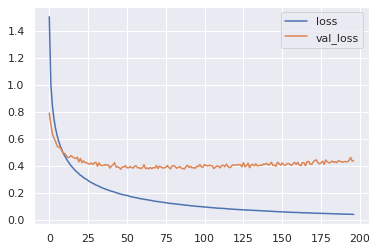

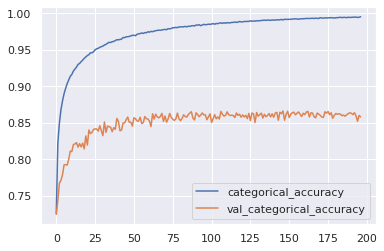

In [65]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [66]:
y_pred = model.predict(x_test)

286/286 [==============================] - 0s 1ms/step


In [67]:
predicted_codes = y_pred.argmax(axis=1)
confidence = y_pred.max(axis=1)
pd.Series(confidence).describe()

count    9148.000000
mean        0.917969
std         0.145996
min         0.279785
25%         0.906738
50%         0.999023
75%         1.000000
max         1.000000
dtype: float64

In [68]:
true_classes = [classes[c] for c in y_test.argmax(axis=1)]
pd.Series(true_classes).value_counts()

Empty                  3793
2pn                     944
2 Cell                  719
Syngamy                 624
Expanded Blastocyst     399
Morula                  382
Cavitating morula       381
Compacting 8 cell       359
8 Cell                  341
Blastocyst              326
6 Cell                  276
Early blast             224
4 Cell                  197
5 Cell                  183
dtype: int64

In [69]:
validation_df = pd.DataFrame()
validation_df["true_class"] = true_classes
validation_df["predicted_class"] = [classes[c] for c in predicted_codes]
validation_df["confidence"] = confidence
validation_df

,true_class,predicted_class,confidence
0,2 Cell,2 Cell,0.997559
1,2 Cell,2 Cell,0.668457
2,2 Cell,2 Cell,0.798828
3,2 Cell,4 Cell,0.743652
4,2 Cell,4 Cell,0.638672
...,...,...,...
9143,Syngamy,2pn,0.827637
9144,Syngamy,2pn,0.919922
9145,Syngamy,Syngamy,0.986328
9146,Syngamy,2pn,0.884766


In [70]:
validation_df.groupby("predicted_class").confidence.median()

predicted_class
2 Cell                 0.956543
2pn                    0.991699
3 Cell                 0.727051
4 Cell                 0.926758
5 Cell                 0.821777
6 Cell                 0.926758
8 Cell                 0.881348
Blastocyst             0.942871
Cavitating morula      0.903809
Compacting 8 cell      0.834473
Early blast            0.858398
Empty                  1.000000
Expanded Blastocyst    0.995117
Morula                 0.838867
Syngamy                0.973633
Name: confidence, dtype: float16

In [71]:
validation_df.to_csv("validation_predictions.csv", index=False)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

             2 Cell       0.94      0.79      0.86       719
                2pn       0.87      0.80      0.84       944
             3 Cell       0.00      0.00      0.00         0
             4 Cell       0.69      0.89      0.78       197
             5 Cell       0.62      0.36      0.45       183
             6 Cell       0.72      0.74      0.73       276
             8 Cell       0.72      0.75      0.74       341
         Blastocyst       0.74      0.80      0.77       326
  Cavitating morula       0.75      0.72      0.73       381
  Compacting 8 cell       0.66      0.66      0.66       359
        Early blast       0.63      0.61      0.62       224
              Empty       1.00      1.00      1.00      3793
Expanded Blastocyst       0.92      0.86      0.89       399
             Morula       0.71      0.68      0.70       382
            Syngamy       0.74      0.83      0.78       624

           accuracy   

Text(66.5, 0.5, 'True')

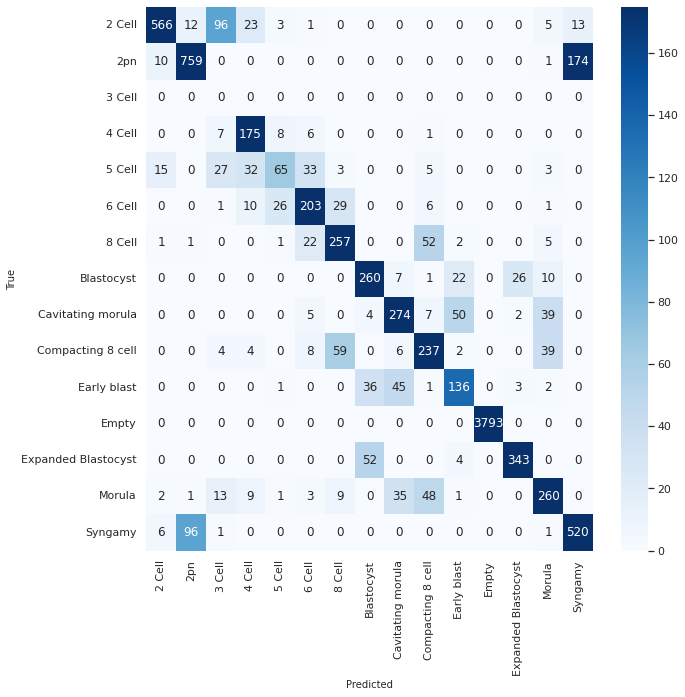

In [90]:
print(classification_report(validation_df["true_class"], validation_df["predicted_class"]))
confusion = confusion_matrix(validation_df["true_class"], validation_df["predicted_class"])
print(np.quantile(confusion, np.arange(0, 1, .1)))
plt.figure(figsize=(10,10))
s = sns.heatmap(
    confusion,
    annot=True,
    cmap='Blues',
    fmt="g",
    xticklabels=classes,
    yticklabels=classes,
    vmax=np.quantile(confusion, .95)
)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)